In [1]:
import pandas as pd
import networkx as nx
import geopandas as gpd
import json 
from shapely.geometry import LineString

import warnings
warnings.filterwarnings("ignore")

# Récuperation des coordonnées GPS des gares

In [2]:
f = open('gares_pologne_perso.json')
geo_data = json.load(f)
df=pd.DataFrame(geo_data).T
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.loc[:,1], df.loc[:,0]), crs="EPSG:4326"
)
gdf.head(5)
gdf.drop(columns=[0,1], inplace=True)
f.close()
gdf.head(5)

,geometry
warszawa ochota,POINT (20.98979 52.22555)
warszawa powiśle,POINT (21.02645 52.23331)
warszawa stadion,POINT (21.04447 52.24615)
gdańsk politechnika,POINT (18.62689 54.37449)
gdańsk stocznia,POINT (18.64162 54.36485)


In [3]:
gdf.reset_index().explore()

# Création du graphe des connexions 

### Fonction qui récupére pour chaque trajet (chaque connexion, il y en a 900 ) les gares parcourus ( 300 gares)

In [4]:
def fonction_parser(df):
    df=df.sort_values("arrival")
    liste_stations=[df.loc[:,"connection"].iloc[0].split(" - ")[0]]
    liste_stations=liste_stations+list(df.loc[:,"name"].drop_duplicates())
    
    name_last=df.loc[:,"connection"].iloc[0].split(" - ")[1]
    if name_last not in liste_stations:
        liste_stations.append(name_last)
        
    return pd.Series({"stations": liste_stations})

data=pd.read_csv("delays.csv")
data.loc[:, "name"]=data.loc[:, "name"].apply(lambda x:x.lower())
data.loc[:, "connection"]=data.loc[:, "connection"].apply(lambda x:x.lower())

In [5]:
les_lignes=data.groupby(by=["connection"], as_index=False).apply(lambda dfr:fonction_parser(dfr))
ensemble_des_gares=list(set(list([item for sublist in list(les_lignes.loc[:, "stations"])
                                  for item in sublist])))
les_lignes.head(5)

,connection,stations
0,bednary - warszawa wschodnia,"[bednary, jasionna łowicka, kęszyce, nowa such..."
1,białogard - wrocław główny,"[białogard, poznań główny, wrocław mikołajów, ..."
2,białystok - szczecin główny,"[białystok, tczew, gdańsk główny, gdańsk wrzes..."
3,białystok - warszawa wschodnia,"[białystok, warszawa wschodnia]"
4,białystok - warszawa zachodnia,"[białystok, warszawa wschodnia, warszawa centr..."


In [6]:
gdf.loc[:, "departs"]=les_lignes.loc[:, "connection"].apply(lambda x:x.split(" - ")[0]).value_counts()
gdf.loc[:, "arrivees"]=les_lignes.loc[:, "connection"].apply(lambda x:x.split(" - ")[1]).value_counts()

il est notable que la majorité des gares ne sont pas dans les stations, autrement dit la colonne name mais dans le nom de la connexion (probablement des directs)

### Fonction de matching des coordonnées géographiques des gares 

In [7]:
def position_gps_station(nom_des_gares):
    poland_train_station=gpd.read_file("gares_pologne_OpenStreetMap.geojson")
    poland_train_station=poland_train_station[["name", "geometry"]]

    #nom des gares dans les données OSM
    names_train_geo_data=list(poland_train_station.loc[:, "name"].dropna().apply(lambda x:x.lower()).unique())

    names_train_arrival_match=[]
    names_train_arrival_no_match=[]

    for k in nom_des_gares:
        if k in names_train_geo_data:
            names_train_arrival_match.append(k)  #nom des gars present dans OSM et nos données
        else:
            names_train_arrival_no_match.append(k) #données manquantes
    print("le nombre de gares est de {}".format(len(nom_des_gares)))
    print("le nombre de match avec les données OSM est de {}".format(len(names_train_arrival_match)))
    print("le nombre de données manquantes avec les données OSM est de {}".format(len(names_train_arrival_no_match)))
    # les données manquantes ont été recupérées à la main
    dictio_no_match={
            "warszawa ochota":[52.22554663399867, 20.989786751231804],
            "warszawa powiśle" :[52.23330824744124, 21.026448539314025],
            "warszawa stadion" :[52.24615163736464, 21.04447145650656],
            "gdańsk politechnika" :[54.37448736289704, 18.626886212469987],
            "gdańsk stocznia" : [54.364852891575815, 18.64162082411324],
            "gdańsk zaspa" :[54.39189224600255, 18.590668426806022],
            "gdańsk przymorze-uniwersytet" :[54.40090608931694, 18.57689330452628],
            "sopot wyścigi" :[54.43096078855212, 18.565436827816196],
            "gdańsk żabianka-awfis" :[54.420663923317925, 18.56844480452754],
            "sopot kamienny potok" : [54.457550691334404, 18.553591024119495],
            "gdynia redłowo": [54.49157174072401, 18.538453812477833],
            "gdynia wzgórze św.maksymiliana" :[54.50811265343659, 18.535506424122943],
            "katowice piotrowice": [50.213856762331794, 18.97140538706005],
            "gdynia leszczynki": [54.54141183204659, 18.47813769713875],
            "gdynia stocznia-uniwersytet morski": [54.525853830620385, 18.519135094739987],
            "gdynia cisowa" :[54.55019497983757, 18.445403852961352],
            "wejherowo-nanice" : [54.60389440454935, 18.24874710084148], 
            "rumia janowo":[54.5590768043962, 18.405771468304344],
            "wejherowo śmiechowo": [54.60231307800671, 18.27485921008756],
            "gdańsk oliwa": [54.40995236452583, 18.571816352951874],
            "warszawa śródmieście": [52.228964985738074, 21.00302228616379],
            "reda pieleszewo": [54.60284473524504, 18.317672997142957],
            "piastów": [52.18274206872292, 20.842628539310763],
            "warszawa ursus niedźwiadek": [52.19165782057896, 20.86974236944766],
            "warszawa ursus": [52.196391196697626, 20.884311944463292],
            "warszawa służewiec": [52.18034968848375, 20.98731168903624],
            "świder": [52.12139870898538, 21.251272696977974],
            "józefów": [52.13639434629432, 21.236466625814458],
            "michalin": [52.14849190517281, 21.224232523966034],
            "warszawa miedzeszyn": [52.17300071242772, 21.199816981638882],
            "warszawa radość": [52.18604491628996, 21.186809339310923],
            "katowice brynów": [50.24431163910127, 18.98319576617191],
            "katowice szopienice południowe": [50.25896963929434, 19.092149391310002],
            "warszawa międzylesie": [52.20420126763813, 21.168721694680563],
            "warszawa anin": [52.21296782883813, 21.159905939312804],
            "warszawa gocławek": [52.23697654229566, 21.13562708164314],
            "warszawa olszynka grochowska": [52.249745393100625, 21.106894839315117],
            "wrocław mikołajów": [51.11533125764548, 16.99820273184451],
            "jasionna łowicka": [52.124593624245826, 20.123626352800105],
            "kęszyce": [52.13822338704833, 20.147849064444983],
            "nowa sucha": [52.15815683606495, 20.167066355619898],
            "kornelin": [52.182943393672595, 20.206109693283473],
            "mysłaków": [52.09216273308975, 20.014635829409727],
            "warszawa zachodnia peron 9" : [52.22206504881521, 20.96136918173398],
            "tychy lodowisko": [50.10794472287606, 19.000068585841852],
            "piasecznica": [52.21000428440808, 20.343766624233822],
            "wrocław stadion": [51.137161371731445, 16.94052603749763],
            "gdańsk śródmieście": [54.34611398000503, 18.64417707262767],
            "busko-zdrój": [50.46184802994265, 20.685946941343797],
            "łódź olechów łoc": [51.729100805222494, 19.572940840022564],
            "warszawa grochów": [52.257396303512664, 21.07826140820668],
            "kielce": [50.87430327141941, 20.61810801815472],
            "mezimesti": [50.62633050218276, 16.242812395136905],
            "bohumin vrbice": [49.88119175840591, 18.321712253426664],
            "zator": [50.00216732763411, 19.429578777176758],
            "tantow": [53.27063730472869, 14.349695564621028],
            "loecknitz": [53.456219434547194, 14.215198865570851],
            "bohumin": [49.901024544964564, 18.35934950064783],
            "wołomin słoneczna": [52.354361623396095, 21.25600868705159],
            "frankfurt/oder": [52.337145683379916, 14.54598504905191],
            "lichkov": [50.09718466189737, 16.658239404890207],
            "świnoujście port": [53.90174388090549, 14.260569367844056],
            "forst lausitz": [51.738921258953, 14.63741072219243],
            "jagodin": [51.19835730624239, 23.895416297360295]
            }

    """
    ajout des match avec OSM dans le ditionnaire des données manquantes et enregistrement d'un json
    pour les coordonées gps de toutes les gares
    """
    
    poland_train_station.dropna(inplace=True)
    poland_train_station.loc[:, "name"]=poland_train_station.loc[:, "name"].apply(lambda x:x.lower())
    poland_train_station.set_index("name", inplace=True)
    for k in names_train_arrival_match:
        dictio_no_match[k]=[poland_train_station.loc[k, "geometry"].y, 
                            poland_train_station.loc[k, "geometry"].x]


    with open("coordinate_train_station.json", "w") as outfile: 
        json.dump(dictio_no_match, outfile)
position_gps_station(ensemble_des_gares)

le nombre de gares est de 336
le nombre de match avec les données OSM est de 272
le nombre de données manquantes avec les données OSM est de 64


### Création des tuples pour créer les graphes de connexion (un géographique(geopandas) et l'autre avec NetworkX)

Note : Il y a actuellment un problème parce que si A => B existe et que B => A existe aussi ils sont comptés séparément, et l'un apparaitrait sur l'autre, j'ai checké quasi 50% des connexions affichés existent dans le sens inverse ce qui est assez logique à vrai dire 

In [8]:
tuples=les_lignes.loc[:, "stations"].apply(lambda x:list(zip(x[:-1], x[1:])))

# création des tuple A=>B
liste_tuples_gdf=list(map(lambda x:dict(zip(["start", "end"], x)), [item for sublist in list(tuples) for item in sublist]))
liste_tuples_nx=list(set([item for sublist in list(tuples) for item in sublist]))

#création de la feature du nombre d'arrêts à une gare
gdf.loc[:, "Nb arrets"]=pd.Series([item for sublist in [item for sublist in list(tuples) for item in sublist] for item in sublist]).value_counts()

df_graphe=pd.DataFrame(liste_tuples_gdf).value_counts().reset_index().rename(columns={0:"nb_occurence_passage"})

#Création de la LineString de coordonnées géospatiales A=>B
geometry_linestring=df_graphe.apply(lambda row:LineString([gdf.loc[row.start, "geometry"],gdf.loc[row.end, "geometry"]]), axis=1)
df_graphe_gdf = gpd.GeoDataFrame(df_graphe, crs="EPSG:4326", geometry=geometry_linestring)
df_graphe_gdf.head(4)

,start,end,nb_occurence_passage,geometry
0,warszawa ochota,warszawa zachodnia,73,"LINESTRING (20.98979 52.22555, 20.96517 52.22016)"
1,warszawa powiśle,warszawa śródmieście,73,"LINESTRING (21.02645 52.23331, 21.00302 52.22896)"
2,warszawa śródmieście,warszawa ochota,73,"LINESTRING (21.00302 52.22896, 20.98979 52.22555)"
3,warszawa stadion,warszawa powiśle,73,"LINESTRING (21.04447 52.24615, 21.02645 52.23331)"


### Transformation pour gérer les cas des connections A=>B et B=>A superposées

In [9]:
df_graphe_gdf.loc[:, "link"]=df_graphe_gdf.apply(lambda row : " - ".join(sorted([row.loc["start"], row.loc["end"]])), axis=1)

first_item=df_graphe_gdf.loc[df_graphe_gdf.loc[:, "link"].drop_duplicates(keep="first").index, :]
second_item=df_graphe_gdf.loc[df_graphe_gdf.index.difference(first_item.index, sort=False), :]
first_item=first_item.set_index("link").rename(columns={"start":"A_start", "end":"A_end", "nb_occurence_passage":"A_nb_occurence_passage"})
second_item=second_item.set_index("link").drop(columns=["geometry"]).rename(columns={"start":"B_start", "end":"B_end", "nb_occurence_passage":"B_nb_occurence_passage"})

df_graphe_gdf=pd.concat([first_item, second_item], axis=1)
df_graphe_gdf.loc[:, "trafic_total"]=df_graphe_gdf.loc[:, "A_nb_occurence_passage"]+df_graphe_gdf.loc[:, "B_nb_occurence_passage"]
df_graphe_gdf.reset_index(inplace=True)

### Cartographie du graphe et des noeuds

In [10]:
import folium
from shapely.geometry import Polygon, mapping

maps = folium.Map(location=[gdf.dissolve().centroid.iloc[0].y, gdf.dissolve().centroid.iloc[0].x],zoom_start=6)

folium.TileLayer('openstreetmap', show=True).add_to(maps)
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        show=False
       ).add_to(maps)

f_graphe = folium.FeatureGroup(name="Graphe destination - arrivée", show=True).add_to(maps)
f_arret = folium.FeatureGroup(name="Nb arrets gare de", show=False).add_to(maps)
f_departs = folium.FeatureGroup(name="Nb de départs gare de ", show=True).add_to(maps)
f_arrivees = folium.FeatureGroup(name="Nb d'arrivées gare de", show=True).add_to(maps)
f_gares = folium.FeatureGroup(name="gare", show=True).add_to(maps)


gdf.loc[gdf.loc[:, "departs"].isna(), "departs"]=0
gdf.loc[gdf.loc[:, "arrivees"].isna(), "arrivees"]=0
gdf.loc[gdf.loc[:,"Nb arrets"].isna(), "Nb arrets"]=0


for k in gdf.reset_index().iterrows():      
    if k[1]["Nb arrets"]!=0:
        folium.CircleMarker([k[1]["geometry"].y, k[1]["geometry"].x],
                            radius=k[1]["Nb arrets"]/4,fill=True, color="purple",
                            tooltip='<b>{}</b><br><br>{}'.format(k[1].loc["index"], 
                                                                "<br>".join(list(map(lambda x:x[0]+" "+str(x[1]), 
                                                                                     zip(["Départs:" , "Arrivées:", "Nb Arrêts:"], 
                                                                list(k[1].loc[["departs" , "arrivees", "Nb arrets"]]))))))
                           ).add_to(f_arret)

    if k[1]["departs"]!=0:
        folium.CircleMarker([k[1]["geometry"].y, k[1]["geometry"].x],
                            radius=k[1]["departs"]/4,fill=True, color="green",
                            tooltip='<b>{}</b><br><br>{}'.format(k[1].loc["index"], 
                                        "<br>".join(list(map(lambda x:x[0]+" "+str(x[1]), 
                                                             zip(["Départs:" , "Arrivées:", "Nb Arrêts:"], 
                                        list(k[1].loc[["departs" , "arrivees", "Nb arrets"]]))))))
                           ).add_to(f_departs)
    
    if k[1]["arrivees"]!=0:
        folium.CircleMarker([k[1]["geometry"].y, k[1]["geometry"].x],
                        radius=k[1]["arrivees"]/4,fill=True, color="red",
                        tooltip='<b>{}</b><br><br>{}'.format(k[1].loc["index"], 
                                            "<br>".join(list(map(lambda x:x[0]+" "+str(x[1]), 
                                                                 zip(["Départs:" , "Arrivées:", "Nb Arrêts:"], 
                                            list(k[1].loc[["departs" , "arrivees", "Nb arrets"]]))))))
                       ).add_to(f_arrivees)
    
    folium.CircleMarker([k[1]["geometry"].y, k[1]["geometry"].x],
                    radius=1,fill=True, color="orange",
                    tooltip='<b>{}</b><br><br>{}'.format(k[1].loc["index"], 
                    "<br>".join(list(map(lambda x:x[0]+" "+str(x[1]), 
                                         zip(["Départs:" , "Arrivées:", "Nb Arrêts:"], 
                    list(k[1].loc[["departs" , "arrivees", "Nb arrets"]]))))))
                   ).add_to(f_gares)

for k in df_graphe_gdf.iterrows():
    folium.PolyLine([list(x[::-1]) for x in mapping(k[1].geometry)["coordinates"]], 
                    weight=k[1].trafic_total/4, color="darkblue",
                    tooltip='<b>{}</b><br>{}'.format(k[1].loc["index"], 
                                            "<br>".join(["Total : {}".format(k[1].trafic_total) , 
                                                         "{} => {}:{}".format(k[1].A_start, k[1].A_end, k[1].A_nb_occurence_passage),
                                                         "{} => {}:{}".format(k[1].B_start, k[1].B_end, k[1].B_nb_occurence_passage)])) 
                                            
                   
                   ).add_to(f_graphe)
    
folium.LayerControl().add_to(maps)
maps

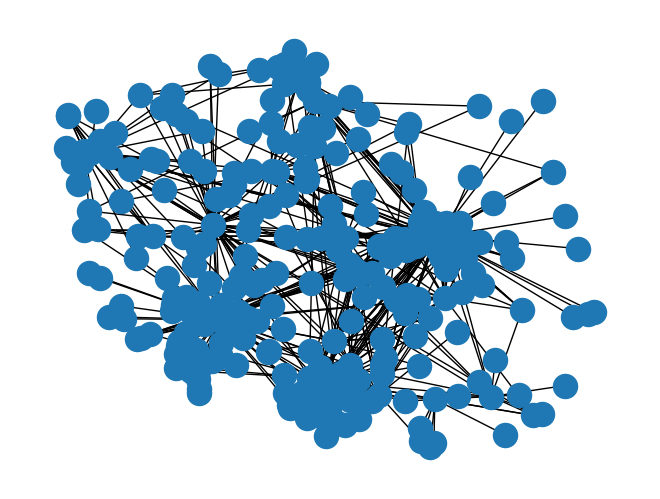

In [11]:
G = nx.Graph()

for k in geo_data:
    G.add_node(k, pos=tuple(geo_data[k][::-1]))


G.add_edges_from(liste_tuples_nx)
pos=nx.get_node_attributes(G,'pos')
nx.draw(G,pos)